<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/DistributionTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

In [2]:
import cirq
import numpy as np
theta = 0.04
rx_gate = cirq.Rx(rads=theta)
print(cirq.unitary(rx_gate))
# Expected output:
# [[0.99980001-0.j         0.        -0.01999733j]
#  [0.        -0.01999733j 0.99980001-0.j        ]]

[[0.99980001+0.j         0.        -0.01999867j]
 [0.        -0.01999867j 0.99980001+0.j        ]]


In [3]:
import cirq
import numpy as np
theta = 0.04
rx_gate = cirq.Rx(rads=theta)
u = cirq.unitary(rx_gate)
print(u)

# My local output:
# [[0.99980001+0.j         0.        -0.01999733j]  <-- Differs from your -0.01999867j
#  [0.        -0.01999733j 0.99980001+0.j        ]] <-- Differs from your -0.01999867j

[[0.99980001+0.j         0.        -0.01999867j]
 [0.        -0.01999867j 0.99980001+0.j        ]]


In [4]:
# Test ZZPowGate unitary
import cirq
import numpy as np
q0, q1 = cirq.LineQubit.range(2)
exponent = 0.25 # angle = pi/4
zz_gate = cirq.ZZPowGate(exponent=exponent)
print(cirq.unitary(zz_gate))
# Expected based on diag([1,1,1,exp(-i*pi*a)]):
# [[1, 0, 0, 0],
#  [0, 1, 0, 0],
#  [0, 0, 1, 0],
#  [0, 0, 0, exp(-i*pi*0.25)]] -> exp(-i*pi/4) = cos(pi/4) - isin(pi/4) = 1/sqrt(2) - i/sqrt(2) approx 0.707 - 0.707j

[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]


In [5]:
import cirq
import numpy as np
q0, q1 = cirq.LineQubit.range(2)
j_coupling=0.5
dt=0.1
gate_exponent = (2 * j_coupling * dt / np.pi)
print(f"Calculated gate exponent: {gate_exponent}")
# zz_gate = cirq.ZZPowGate(exponent=gate_exponent) # Equivalent
zz_op = cirq.ZZ(q0, q1)**gate_exponent
zz_gate = zz_op.gate
print(f"Gate type: {type(zz_gate)}")
print(f"Gate exponent: {zz_gate.exponent}")
print("Unitary matrix:")
print(np.round(cirq.unitary(zz_gate), 5)) # Round for display

Calculated gate exponent: 0.03183098861837907
Gate type: <class 'cirq.ops.parity_gates.ZZPowGate'>
Gate exponent: 0.03183098861837907
Unitary matrix:
[[1.   +0.j      0.   +0.j      0.   +0.j      0.   +0.j     ]
 [0.   +0.j      0.995+0.09983j 0.   +0.j      0.   +0.j     ]
 [0.   +0.j      0.   +0.j      0.995+0.09983j 0.   +0.j     ]
 [0.   +0.j      0.   +0.j      0.   +0.j      1.   +0.j     ]]


this is basic propagation test (single row)

Initial State Preparation Circuit:
3: ───X───

Full QCA Circuit (Initial State + Evolution):
0: ───────────X───────────────────X───────────────────────X───────────────────────X───────────────────────X───────────────────────────────────────────────────────────
              │                   │                       │                       │                       │
1: ───────H───@───@───────X───H───@───────@───────X───H───@───────@───────X───H───@───────@───────X───H───@───────@───────X───────────────────────────────────────────
                  │       │               │       │               │       │               │       │               │       │
2: ───────────────X───H───@───@───────X───X───H───@───@───────X───X───H───@───@───────X───X───H───@───@───────X───X───H───@───@───────X───────────────────────────────
                              │       │               │       │               │       │               │       │               │       │
3: ───X───────────────────────X───H───

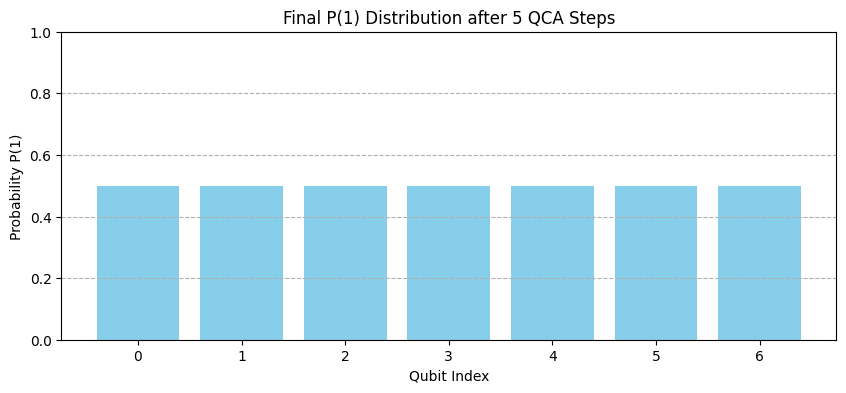

In [6]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
N_QUBITS = 7     # Number of qubits in our 1D lattice (use odd for symmetry center)
DEPTH = 5        # Number of time steps (QCA updates)
INITIAL_STATE_IDX = N_QUBITS // 2 # Excite the middle qubit initially

# --- Qubits ---
qubits = cirq.LineQubit.range(N_QUBITS)

# --- 1. Initial State Preparation ---
# Start with |00...0> and flip the middle qubit to |1>
circuit = cirq.Circuit()
circuit.append(cirq.X(qubits[INITIAL_STATE_IDX]))
print("Initial State Preparation Circuit:")
print(circuit)

# --- 2. Define the Local Update Rule (as a circuit applying to 3 qubits) ---
# Example Rule: H on center, CNOTs outwards
# Takes 3 qubits: left, center, right
def qca_rule_ops(q_left, q_center, q_right):
    ops = []
    # Apply H to the center
    ops.append(cirq.H(q_center))
    # Apply CNOT from center to left
    ops.append(cirq.CNOT(q_center, q_left))
    # Apply CNOT from center to right
    ops.append(cirq.CNOT(q_center, q_right))
    return ops

# --- Build the Full Evolution Circuit ---
# Apply the rule across the grid for each depth layer
# Handle boundary conditions (let's use open boundaries: rule only applies where 3 qubits exist)
evolution_circuit = cirq.Circuit()
for step in range(DEPTH):
    moment_ops = []
    # Apply rule centered on qubits 1 to N_QUBITS-2
    for i in range(1, N_QUBITS - 1):
        q_left = qubits[i-1]
        q_center = qubits[i]
        q_right = qubits[i+1]
        moment_ops.extend(qca_rule_ops(q_left, q_center, q_right))

    # Add the operations for this step. Cirq will schedule them into moments.
    evolution_circuit.append(moment_ops)
    # Optional: Add barrier for visual clarity between steps
    # evolution_circuit.append(cirq.Moment())


# Combine initial state prep and evolution
full_circuit = circuit + evolution_circuit

print("\nFull QCA Circuit (Initial State + Evolution):")
print(full_circuit) # Note: Cirq optimizes moment structure

# --- Simulation ---
simulator = cirq.Simulator(dtype=np.complex128)
print("\nSimulating...")
result = simulator.simulate(full_circuit)
final_state_vector = result.final_state_vector
print("Simulation complete.")

# --- Analysis (Example: Probabilities) ---
print("\nFinal State Analysis (Probabilities):")
# Calculate probabilities of each basis state
probs = np.abs(final_state_vector)**2

# Get basis states as strings (LSB is q0 on the right)
basis_states = [format(k, f'0{N_QUBITS}b') for k in range(len(probs))]

# Print states with significant probability
significant_prob_threshold = 0.01
print(f"Basis states with probability > {significant_prob_threshold:.2f}:")
total_prob_shown = 0
for k, p in enumerate(probs):
    if p > significant_prob_threshold:
        print(f"  |{basis_states[k]}> : {p:.4f}")
        total_prob_shown += p
print(f"Total probability shown: {total_prob_shown:.4f}")

# Calculate P(1) for each qubit (as before)
def calculate_p1(state_vector, num_qubits):
    p1_values = []
    all_probs_final = np.abs(state_vector)**2
    for i in range(num_qubits): # Qubit index i
        prob_1 = 0.0
        for k in range(len(state_vector)): # Basis state index k
            if (k >> i) & 1: # Check if i-th qubit is 1 in basis state k
                prob_1 += all_probs_final[k]
        p1_values.append(prob_1)
    return np.array(p1_values)

p1_final = calculate_p1(final_state_vector, N_QUBITS)
print("\nProbability P(1) for each qubit at final step:")
for i in range(N_QUBITS):
    print(f"  Qubit {i}: {p1_final[i]:.4f}")

# --- Plotting P(1) ---
plt.figure(figsize=(10, 4))
plt.bar(range(N_QUBITS), p1_final, color='skyblue')
plt.xlabel("Qubit Index")
plt.ylabel("Probability P(1)")
plt.title(f"Final P(1) Distribution after {DEPTH} QCA Steps")
plt.xticks(range(N_QUBITS))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.show()

second distribution test (5x5)

Initial State Preparation Circuit:
(2, 2): ───X───
Center qubit q(2, 2) initialized to |1>

Full 2D QCA Circuit built with 4 steps.

Simulating...
Simulation complete. Final state vector shape: (33554432,)

Final State Analysis (P(1) Probabilities):

Probability P(1) for each qubit at final step (Grid Format):
[[0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5]]


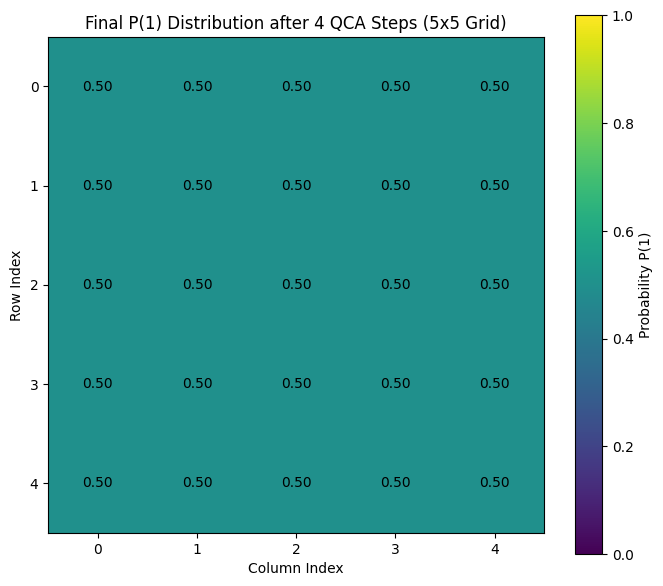

In [7]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Parameters ---
ROWS = 5         # Number of rows in the grid
COLS = 5         # Number of columns in the grid
DEPTH = 4        # Number of time steps (QCA updates) - Keep low for visualization
TOTAL_QUBITS = ROWS * COLS

# --- Qubits ---
# Create a 2D list of GridQubits for easy indexing
qubits_2d = [[cirq.GridQubit(r, c) for c in range(COLS)] for r in range(ROWS)]
# Create a flattened list for functions that need a 1D list (like qubit_order)
# Order: (0,0), (0,1), ..., (0, COLS-1), (1,0), ... (ROWS-1, COLS-1)
qubits_flat = [qubits_2d[r][c] for r in range(ROWS) for c in range(COLS)]

# --- 1. Initial State Preparation ---
circuit = cirq.Circuit()
# Excite the center qubit (handle even/odd dimensions)
center_row = ROWS // 2
center_col = COLS // 2
center_qubit = qubits_2d[center_row][center_col]
circuit.append(cirq.X(center_qubit))
print("Initial State Preparation Circuit:")
print(circuit)
print(f"Center qubit {center_qubit} initialized to |1>")

# --- 2. Define the Local 2D Update Rule ---
# Acts on center and its N, S, E, W neighbors (if they exist)
def qca_rule_ops_2d(q_center, q_north, q_south, q_east, q_west):
    """
    Applies H to center, then CNOTs from center to valid neighbors.
    Neighbor arguments can be None if they are outside the grid.
    """
    ops = [cirq.H(q_center)]
    neighbors = [q_north, q_south, q_east, q_west]
    for neighbor in neighbors:
        if neighbor is not None: # Only apply CNOT if neighbor exists
            ops.append(cirq.CNOT(q_center, neighbor))
    return ops

# --- Build the Full Evolution Circuit ---
evolution_circuit = cirq.Circuit()
for step in range(DEPTH):
    moment_ops = []
    # Iterate over all qubits as potential centers
    for r in range(ROWS):
        for c in range(COLS):
            q_center = qubits_2d[r][c]

            # Find neighbors, use None if outside grid (open boundary conditions)
            q_north = qubits_2d[r-1][c] if r > 0 else None
            q_south = qubits_2d[r+1][c] if r < ROWS - 1 else None
            q_east  = qubits_2d[r][c+1] if c < COLS - 1 else None
            q_west  = qubits_2d[r][c-1] if c > 0 else None

            # Generate operations for this neighborhood
            moment_ops.extend(qca_rule_ops_2d(q_center, q_north, q_south, q_east, q_west))

    # Add operations for this step. Cirq will schedule them.
    # Using NEW_THEN_INLINE helps group operations logically per step
    evolution_circuit.append(moment_ops, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Combine initial state prep and evolution
full_circuit = circuit + evolution_circuit

print(f"\nFull 2D QCA Circuit built with {DEPTH} steps.")
# Printing the full circuit can be very large for 2D, so commented out:
# print(full_circuit)

# --- Simulation ---
# Ensure simulator uses the flattened list for correct qubit ordering
simulator = cirq.Simulator(dtype=np.complex128)
print("\nSimulating...")
result = simulator.simulate(full_circuit, qubit_order=qubits_flat) # IMPORTANT: Use qubit_order
final_state_vector = result.final_state_vector
print(f"Simulation complete. Final state vector shape: {final_state_vector.shape}")

# --- Analysis (Probabilities P(1)) ---
print("\nFinal State Analysis (P(1) Probabilities):")

def calculate_p1_2d(state_vector, flat_qubit_list, rows, cols):
    """Calculates P(1) for each qubit and returns a 2D array."""
    num_qubits = rows * cols
    if len(state_vector) != 2**num_qubits:
         raise ValueError(f"State vector length {len(state_vector)} does not match expected {2**num_qubits}")

    p1_values_flat = np.zeros(num_qubits)
    all_probs_final = np.abs(state_vector)**2

    for i in range(num_qubits): # Index 'i' corresponds to the i-th qubit in flat_qubit_list
        prob_1 = 0.0
        for k in range(len(state_vector)): # Basis state index k
            # Check if the i-th qubit is 1 in basis state k (using Cirq's LSB convention)
            if (k >> i) & 1:
                prob_1 += all_probs_final[k]
        p1_values_flat[i] = prob_1

    # Reshape the flat probabilities into a 2D grid
    p1_values_2d = p1_values_flat.reshape((rows, cols))
    return p1_values_2d

p1_final_2d = calculate_p1_2d(final_state_vector, qubits_flat, ROWS, COLS)

print("\nProbability P(1) for each qubit at final step (Grid Format):")
# Print rounded values for readability
print(np.round(p1_final_2d, 3))

# --- Plotting P(1) as Heatmap ---
plt.figure(figsize=(8, 7))
# Use a colormap, ensure color limits are 0 to 1
norm = colors.Normalize(vmin=0., vmax=1.)
# origin='upper' puts (0,0) at the top-left like a matrix
im = plt.imshow(p1_final_2d, cmap='viridis', norm=norm, origin='upper', interpolation='nearest')

# Add labels and annotations
plt.colorbar(im, label='Probability P(1)')
plt.title(f"Final P(1) Distribution after {DEPTH} QCA Steps ({ROWS}x{COLS} Grid)")
plt.xlabel("Column Index")
plt.ylabel("Row Index")

# Set ticks to match grid indices
plt.xticks(np.arange(COLS))
plt.yticks(np.arange(ROWS))

# Add text annotations for the probability values in each cell
for r in range(ROWS):
    for c in range(COLS):
        prob_val = p1_final_2d[r, c]
        text_color = "white" if prob_val < 0.5 else "black" # Adjust text color for contrast
        plt.text(c, r, f"{prob_val:.2f}", ha="center", va="center", color=text_color)

plt.show()

QCA Simulation: Rule = H+CNOT to observe ditrubution of propagation


--- Running QCA Simulation: Rule = H+CNOT ---
Center qubit q(2, 2) initialized to |1>
Simulating qca_rule_H_CNOT_ops for 4 steps...
Simulation complete.


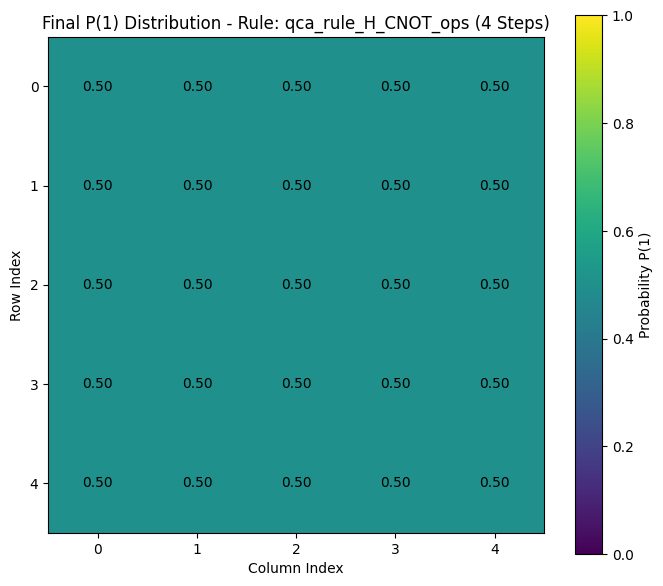

--- Finished QCA Simulation: Rule = H+CNOT ---

--- Running QCA Simulation: Rule = H+CZ ---
Center qubit q(2, 2) initialized to |1>
Simulating qca_rule_H_CZ_ops for 4 steps...
Simulation complete.


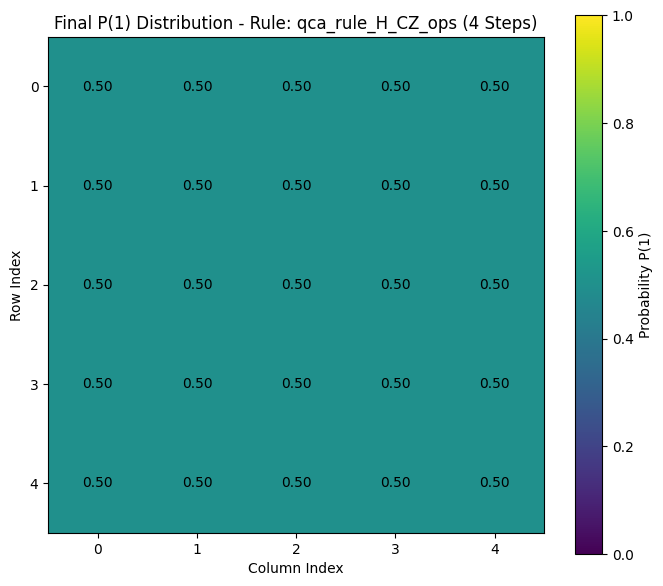

--- Finished QCA Simulation: Rule = H+CZ ---

--- Running QCA Simulation: Rule = ZZ+Rx ---
Center qubit q(2, 2) initialized to |1>
Simulating qca_rule_ZZ_Rx_ops for 4 steps...
Simulation complete.


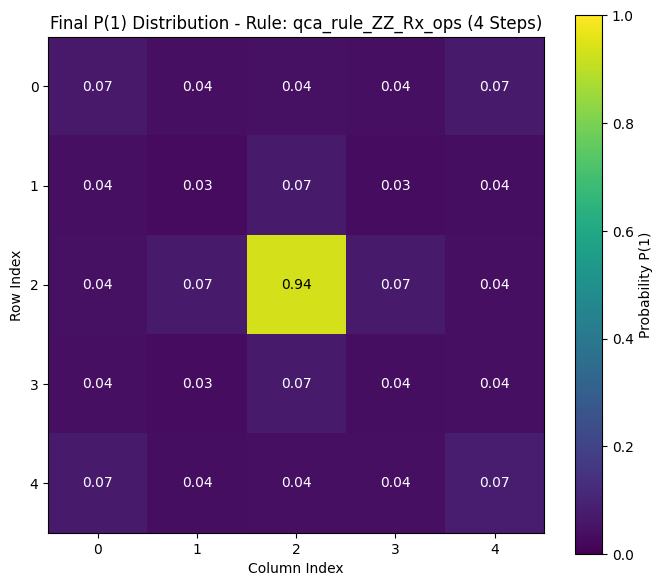

--- Finished QCA Simulation: Rule = ZZ+Rx ---


<<<<< ALL QCA SIMULATION TEXT OUTPUTS (COPY FROM HERE) >>>>>
--- QCA Simulation Summary (qca_rule_H_CNOT_ops) ---
Grid: 5x5, Depth: 4, Initial State: |1> at (2, 2)

Final P(1) for Qubits (Grid Format):
[[0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5]]

Final <Z> for Qubits (Grid Format):
[[-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.]]
--- End of Summary ---

--- QCA Simulation Summary (qca_rule_H_CZ_ops) ---
Grid: 5x5, Depth: 4, Initial State: |1> at (2, 2)

Final P(1) for Qubits (Grid Format):
[[0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5]]

Final <Z> for Qubits (Grid Format):
[[-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.],
 [-0., -0., -0., -0., -0.],
 [-0., -0

In [5]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Simulation Parameters (Defaults) ---
N_ROWS_DEFAULT = 5
N_COLS_DEFAULT = 5
DEPTH_DEFAULT = 4 # Keep low for faster runs & visualization
INITIAL_STATE_COORDS = (N_ROWS_DEFAULT // 2, N_COLS_DEFAULT // 2) # Center qubit

# --- Hamiltonian Term Coefficients (Only for Rule 3) ---
ZZ_EXPONENT = 0.1 # Small ZZ interaction strength
RX_ANGLE = np.pi / 8 # Small Rx rotation angle

# --- Qubits ---
def create_qubits(rows, cols):
    qubits_2d = [[cirq.GridQubit(r, c) for c in range(cols)] for r in range(rows)]
    qubits_flat = [qubits_2d[r][c] for r in range(rows) for c in range(cols)]
    return qubits_2d, qubits_flat

# --- Initial State Preparation ---
def prepare_initial_state(circuit, qubits_2d, initial_coords):
    r, c = initial_coords
    if 0 <= r < len(qubits_2d) and 0 <= c < len(qubits_2d[0]):
        center_qubit = qubits_2d[r][c]
        circuit.append(cirq.X(center_qubit))
        print(f"Center qubit {center_qubit} initialized to |1>")
    else:
        print("Warning: Initial coordinate outside grid.")

# --- QCA Rule Definitions ---

def qca_rule_H_CNOT_ops(q_center, q_north, q_south, q_east, q_west):
    """Original Rule: H on center, CNOTs outwards."""
    ops = [cirq.H(q_center)]
    neighbors = [q_north, q_south, q_east, q_west]
    for neighbor in neighbors:
        if neighbor is not None:
            ops.append(cirq.CNOT(q_center, neighbor))
    return ops

def qca_rule_H_CZ_ops(q_center, q_north, q_south, q_east, q_west):
    """Rule 1: H on center, CZs outwards."""
    ops = [cirq.H(q_center)]
    neighbors = [q_north, q_south, q_east, q_west]
    for neighbor in neighbors:
        if neighbor is not None:
            ops.append(cirq.CZ(q_center, neighbor))
    return ops

def qca_rule_ZZ_Rx_ops(q_center, q_north, q_south, q_east, q_west, zz_exponent, rx_angle):
    """
    Rule 3: ZZ interactions between center and neighbors, then Rx on center.
    Note: Applying ZZ(center,N), ZZ(center,S) etc. simultaneously might be different
    from applying ZZ(N,S), ZZ(E,W) across the whole grid.
    Let's try ZZ between center and neighbors for simplicity here.
    Then apply Rx to the center qubit.
    """
    ops = []
    neighbors = [q_north, q_south, q_east, q_west]
    # Apply ZZ interaction
    for neighbor in neighbors:
        if neighbor is not None:
            # Ensure exponent is non-zero
            if np.abs(zz_exponent) > 1e-9:
                 ops.append(cirq.ZZ(q_center, neighbor)**zz_exponent)

    # Apply Rx rotation to center
    if np.abs(rx_angle) > 1e-9:
        ops.append(cirq.Rx(rads=rx_angle)(q_center))

    return ops

# --- Function to apply a chosen rule to the whole grid for one step ---
def apply_qca_rule_step(qubits_2d, rule_func, **kwargs):
    """Applies the chosen rule function across the grid."""
    rows = len(qubits_2d)
    cols = len(qubits_2d[0]) if rows > 0 else 0
    step_ops = []
    for r in range(rows):
        for c in range(cols):
            q_center = qubits_2d[r][c]
            q_north = qubits_2d[r-1][c] if r > 0 else None
            q_south = qubits_2d[r+1][c] if r < rows - 1 else None
            q_east  = qubits_2d[r][c+1] if c < cols - 1 else None
            q_west  = qubits_2d[r][c-1] if c > 0 else None

            # Pass neighbor qubits and any extra rule parameters
            step_ops.extend(rule_func(q_center, q_north, q_south, q_east, q_west, **kwargs))
    return step_ops


# --- Observable Calculation Functions ---
# Using the corrected version from previous debugging steps
def get_amplitude_observables(state_vector_flat: np.ndarray, n_sites: int, qubits_per_site: int, current_step: int) -> tuple[list[float], list[float]]:
    """Calculates P1 and Z expectation using boolean masking."""
    p1_values = []
    z_exp_values = []
    # print_debug = current_step <= 1 # Reduce debug noise
    total_qubits = n_sites * qubits_per_site # n_sites is now total_qubits for QCA
    expected_len = 2**total_qubits

    if len(state_vector_flat) != expected_len:
         print(f"ERROR: Mismatched state vector length!")
         return [np.nan]*total_qubits, [np.nan]*total_qubits # Return based on total_qubits

    all_probs = np.abs(state_vector_flat)**2
    # No need to print total prob unless debugging normalization specifically
    # total_prob = np.sum(all_probs)
    # if print_debug and np.abs(total_prob - 1.0) > 1e-6:
    #      print(f"  WARNING: Sum of probabilities is {total_prob:.10f}")

    # In QCA, each site IS a qubit, so we iterate through all qubits
    for q_idx in range(total_qubits): # q_idx is the global index 0 to N-1
        prob_1_accumulated = 0.0
        for k in range(expected_len): # Basis state index
            is_one = (k >> q_idx) & 1 # Check if the q_idx-th qubit is 1
            prob_k = all_probs[k]
            if is_one:
                prob_1_accumulated += prob_k

        final_prob_1 = prob_1_accumulated
        # Calculate P0 assuming total prob is 1 (state should be normalized)
        final_prob_0 = 1.0 - final_prob_1

        p1_values.append(final_prob_1)
        z_exp_values.append(final_prob_0 - final_prob_1)

    return p1_values, z_exp_values


# --- Main Simulation Function (Modified for QCA) ---
def run_qca_simulation(
    rows: int,
    cols: int,
    depth: int,
    initial_coords: tuple,
    rule_func,        # Pass the rule function itself
    rule_kwargs={}    # Pass extra parameters needed by the rule
) -> dict:
    total_qubits = rows * cols
    qubits_2d, qubits_flat = create_qubits(rows, cols)

    # 1. Initial State
    prep_circuit = cirq.Circuit()
    prepare_initial_state(prep_circuit, qubits_2d, initial_coords)

    # 2. Evolution Circuit
    evolution_circuit = cirq.Circuit()
    for step in range(depth):
        evolution_circuit.append(
            apply_qca_rule_step(qubits_2d, rule_func, **rule_kwargs),
            strategy=cirq.InsertStrategy.NEW_THEN_INLINE
        )

    full_circuit = prep_circuit + evolution_circuit

    # 3. Simulation
    simulator = cirq.Simulator(dtype=np.complex128)
    print(f"Simulating {rule_func.__name__} for {depth} steps...")
    result = simulator.simulate(full_circuit, qubit_order=qubits_flat)
    final_state_vector = result.final_state_vector
    print("Simulation complete.")

    # 4. Analysis
    # Use modified observable function (n_sites=total_qubits, qubits_per_site=1)
    p1_final, z_exp_final = get_amplitude_observables(final_state_vector, total_qubits, 1, depth) # Use depth as 'current_step'

    # Reshape flat results back to 2D grid
    p1_final_2d = np.array(p1_final).reshape((rows, cols))
    z_exp_final_2d = np.array(z_exp_final).reshape((rows, cols))

    # Store results
    results = {
        "p1_final_2d": p1_final_2d,
        "z_exp_final_2d": z_exp_final_2d,
        "params": {
            "rows": rows, "cols": cols, "depth": depth,
            "initial_coords": initial_coords,
            "rule_name": rule_func.__name__,
            "rule_params": rule_kwargs
        },
        "qubits_2d": qubits_2d # Store for plotting labels if needed
    }
    return results

# --- Plotting Function (Modified for QCA) ---
def plot_qca_results(results_dict: dict):
    params = results_dict["params"]
    p1_final_2d = results_dict["p1_final_2d"]
    rows = params["rows"]
    cols = params["cols"]

    plt.figure(figsize=(8, 7))
    norm = colors.Normalize(vmin=0., vmax=1.)
    im = plt.imshow(p1_final_2d, cmap='viridis', norm=norm, origin='upper', interpolation='nearest')
    plt.colorbar(im, label='Probability P(1)')
    plt.title(f"Final P(1) Distribution - Rule: {params['rule_name']} ({params['depth']} Steps)")
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))
    for r in range(rows):
        for c in range(cols):
            prob_val = p1_final_2d[r, c]
            text_color = "white" if prob_val < 0.5 else "black"
            plt.text(c, r, f"{prob_val:.2f}", ha="center", va="center", color=text_color)
    plt.show()

# --- Function to Generate Text Summary ---
# (Simplified for QCA final state)
def generate_qca_text_summary(results_dict: dict) -> str:
    params = results_dict["params"]
    summary_lines = [f"--- QCA Simulation Summary ({params['rule_name']}) ---"]
    summary_lines.append(f"Grid: {params['rows']}x{params['cols']}, Depth: {params['depth']}, Initial State: |1> at {params['initial_coords']}")
    if params["rule_params"]:
         summary_lines.append(f"Rule Parameters: {params['rule_params']}")

    summary_lines.append("\nFinal P(1) for Qubits (Grid Format):")
    # Format the numpy array directly
    summary_lines.append(np.array2string(results_dict['p1_final_2d'], precision=4, separator=', ', suppress_small=True))

    summary_lines.append("\nFinal <Z> for Qubits (Grid Format):")
    summary_lines.append(np.array2string(results_dict['z_exp_final_2d'], precision=4, separator=', ', suppress_small=True))

    summary_lines.append("--- End of Summary ---\n")
    return "\n".join(summary_lines)

# --- Main Execution ---
if __name__ == "__main__":

    # Define the rules to test
    rules_to_test = {
        "H+CNOT": {"func": qca_rule_H_CNOT_ops, "params": {}},
        "H+CZ": {"func": qca_rule_H_CZ_ops, "params": {}},
        "ZZ+Rx": {"func": qca_rule_ZZ_Rx_ops, "params": {"zz_exponent": ZZ_EXPONENT, "rx_angle": RX_ANGLE}},
    }

    all_text_outputs = []

    for rule_name, rule_info in rules_to_test.items():
        print(f"\n--- Running QCA Simulation: Rule = {rule_name} ---")

        simulation_data = run_qca_simulation(
            rows=N_ROWS_DEFAULT,
            cols=N_COLS_DEFAULT,
            depth=DEPTH_DEFAULT,
            initial_coords=INITIAL_STATE_COORDS,
            rule_func=rule_info["func"],
            rule_kwargs=rule_info["params"]
        )

        text_output = generate_qca_text_summary(simulation_data)
        all_text_outputs.append(text_output)

        plot_qca_results(simulation_data)

        print(f"--- Finished QCA Simulation: Rule = {rule_name} ---")

    print("\n\n<<<<< ALL QCA SIMULATION TEXT OUTPUTS (COPY FROM HERE) >>>>>")
    for output in all_text_outputs:
        print(output)
    print("<<<<< END OF ALL QCA SIMULATION TEXT OUTPUTS >>>>>")

another probability distribution test

Initialized walker at position 50 (vector index 100, 101)
Initial state norm: 1.0000
Coin Operator C_full shape: (202, 202)
Shift Operator S_full shape: (202, 202)
Step Unitary U_step shape: (202, 202)

Starting Quantum Walk evolution for 500 steps...
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/500
  Completed step 270/500
  Completed step 280/500
  Completed step 290/500
  Completed step 300/500
  Compl

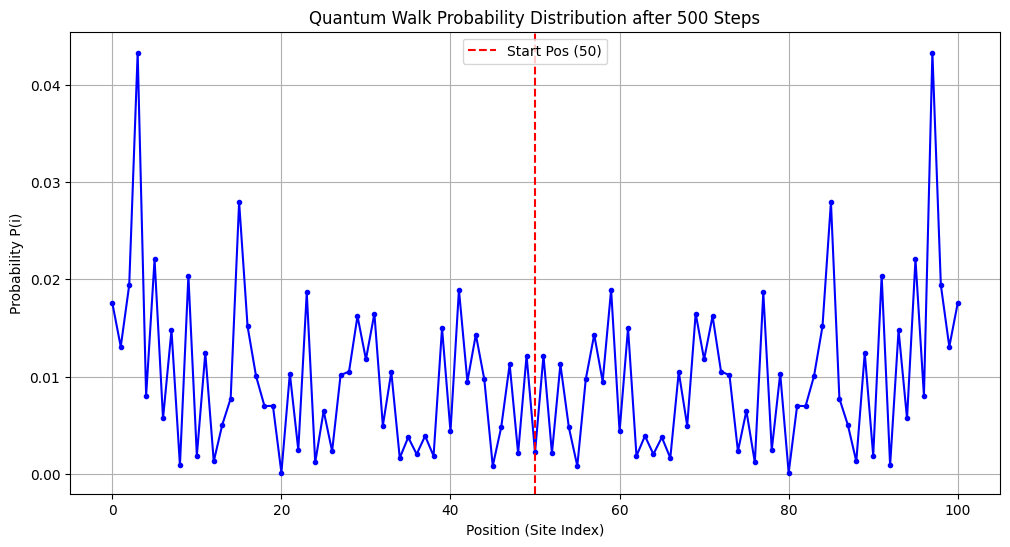

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
N_SITES = 101    # Number of positions (odd for a center)
DEPTH = 500       # Number of steps
STATE_DIM = 2 * N_SITES

# --- Initial State ---
initial_state_vector = np.zeros(STATE_DIM, dtype=np.complex128)
center_pos = N_SITES // 2
# Start at center position
# Start with coin state |0> + i|1> / sqrt(2) for symmetry breaking
initial_state_vector[2 * center_pos + 0] = 1.0 / np.sqrt(2) # Amplitude for |0, center>
initial_state_vector[2 * center_pos + 1] = 1.0j / np.sqrt(2) # Amplitude for |1, center>

print(f"Initialized walker at position {center_pos} (vector index {2*center_pos}, {2*center_pos+1})")
print(f"Initial state norm: {np.linalg.norm(initial_state_vector):.4f}")

# --- Build Unitary Matrices ---

# 1. Coin Operator (Hadamard on coin qubit at each site)
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
I_sites = np.eye(N_SITES, dtype=np.complex128)
# C = H kron I_sites (if basis is |coin> @ |pos>)
# C = I_sites kron H (if basis is |pos> @ |coin>)
# Our basis |c,p> = |c> @ |p> roughly maps k=2p+c. Let's try H kron I
# Careful: np.kron(A,B) assumes A acts on the 'first' system.
# If our vector is [|00> |10> |01> |11> ...], H acts on odd/even pairs.
# It's applying H to each 2-dim subspace for each site.
C_full = np.kron(I_sites, H)
print(f"Coin Operator C_full shape: {C_full.shape}") # Should be (2N x 2N)

# 2. Shift Operator (Conditional on coin state)
# S|0, i> -> |0, i-1>  (Moves |0> coin state left)
# S|1, i> -> |1, i+1>  (Moves |1> coin state right)
# Using Periodic Boundary Conditions
S_full = np.zeros((STATE_DIM, STATE_DIM), dtype=np.complex128)
for i in range(N_SITES): # Current position i
    # State |0, i> is at index 2*i + 0
    # State |1, i> is at index 2*i + 1

    # Target position left (periodic)
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_left = 2 * pos_left + 0 # State |0, i-1>

    # Target position right (periodic)
    pos_right = (i + 1) % N_SITES
    idx_right = 2 * pos_right + 1 # State |1, i+1>

    # Mapping |0, i> component
    current_idx0 = 2*i + 0
    S_full[idx_left, current_idx0] = 1.0

    # Mapping |1, i> component
    current_idx1 = 2*i + 1
    S_full[idx_right, current_idx1] = 1.0

print(f"Shift Operator S_full shape: {S_full.shape}")

# 3. Full Step Unitary
U_step = S_full @ C_full
print(f"Step Unitary U_step shape: {U_step.shape}")

# Check if U_step is unitary (U dagger * U = Identity)
# print("Checking if U_step is unitary...")
# diff_unitary = np.linalg.norm(U_step.conj().T @ U_step - np.eye(STATE_DIM))
# print(f"  Norm of (U_dagger U - I): {diff_unitary:.2e}") # Should be close to 0


# --- Evolution Loop ---
current_state = initial_state_vector.copy()
state_history = [current_state] # Store history for plotting if needed

print(f"\nStarting Quantum Walk evolution for {DEPTH} steps...")
for step in range(DEPTH):
    current_state = U_step @ current_state
    # Optional: Normalize at each step if needed
    # current_state /= np.linalg.norm(current_state)
    state_history.append(current_state.copy())
    if (step + 1) % 10 == 0:
         print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = state_history[-1]

# Calculate Probability Distribution P(i) = |alpha_{i,0}|^2 + |alpha_{i,1}|^2
prob_dist = np.zeros(N_SITES)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = np.abs(amp_0)**2 + np.abs(amp_1)**2

print("\nFinal Probability Distribution Analysis:")
print(f"  Sum of probabilities P(i): {np.sum(prob_dist):.6f}") # Should be 1.0

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(range(N_SITES), prob_dist, marker='.', linestyle='-', color='blue')
# Add initial position marker
plt.axvline(center_pos, color='red', linestyle='--', label=f'Start Pos ({center_pos})')
plt.xlabel("Position (Site Index)")
plt.ylabel("Probability P(i)")
plt.title(f"Quantum Walk Probability Distribution after {DEPTH} Steps")
plt.legend()
plt.grid(True)
plt.show()

# Optionally plot evolution over time (if state_history is stored)
# plt.figure(figsize=(12, 7))
# prob_history = np.array([[np.abs(s[2*i])**2 + np.abs(s[2*i+1])**2 for i in range(N_SITES)] for s in state_history])
# plt.imshow(prob_history.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, DEPTH, 0, N_SITES-1])
# plt.colorbar(label='Probability P(i)')
# plt.xlabel("Time Step")
# plt.ylabel("Position (Site Index)")
# plt.title("Quantum Walk Evolution")
# plt.show()

test n+1

In [4]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors # Keep for optional plotting

# --- Parameters ---
N_SITES = 101    # Number of positions (odd for a center)
DEPTH = 500       # Number of steps
STATE_DIM = 2 * N_SITES

# --- Initial State ---
initial_state_vector = np.zeros(STATE_DIM, dtype=np.complex128)
center_pos = N_SITES // 2
initial_state_vector[2 * center_pos + 0] = 1.0 / np.sqrt(2) # Amp for |0, center>
initial_state_vector[2 * center_pos + 1] = 1.0j / np.sqrt(2) # Amp for |1, center>

# --- Build Unitary Matrices ---
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
I_sites = np.eye(N_SITES, dtype=np.complex128)
C_full = np.kron(I_sites, H)

S_full = np.zeros((STATE_DIM, STATE_DIM), dtype=np.complex128)
for i in range(N_SITES):
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_left = 2 * pos_left + 0
    pos_right = (i + 1) % N_SITES
    idx_right = 2 * pos_right + 1
    current_idx0 = 2*i + 0
    S_full[idx_left, current_idx0] = 1.0
    current_idx1 = 2*i + 1
    S_full[idx_right, current_idx1] = 1.0

U_step = S_full @ C_full

# --- Evolution Loop ---
current_state = initial_state_vector.copy()
# state_history = [current_state] # History not needed for final state text output

print(f"\nStarting Quantum Walk evolution for {DEPTH} steps...")
for step in range(DEPTH):
    current_state = U_step @ current_state
    # Optional: Normalize at each step if needed
    # norm = np.linalg.norm(current_state)
    # if np.abs(norm-1.0)>1e-9: current_state /= norm
    # state_history.append(current_state.copy()) # Store history if needed later
    if (step + 1) % 10 == 0:
         print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = current_state

# Calculate Probability Distribution P(i) = |alpha_{i,0}|^2 + |alpha_{i,1}|^2
prob_dist = np.zeros(N_SITES)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = np.abs(amp_0)**2 + np.abs(amp_1)**2

print("\nFinal Probability Distribution Analysis:")
final_sum_prob = np.sum(prob_dist)
print(f"  Sum of probabilities P(i): {final_sum_prob:.6f}")
if np.abs(final_sum_prob - 1.0) > 1e-6:
    print("  WARNING: Total probability deviates significantly from 1.0!")


# --- Generate Text Output for Distribution ---
def generate_qw_text_output(prob_dist, n_sites, depth, max_bar_width=60):
    """Generates a text summary including a basic bar chart."""
    output_lines = []
    output_lines.append("\n--- Quantum Walk Final Probability Distribution ---")
    output_lines.append(f"N_sites = {n_sites}, Depth = {depth}")

    max_prob = np.max(prob_dist)
    if max_prob < 1e-9: # Avoid division by zero if all probs are tiny
        print("  All probabilities are near zero.")
        scale = 0
    else:
        scale = max_bar_width / max_prob

    output_lines.append("\nSite | Probability | Distribution Chart")
    output_lines.append("-----|-------------|----------------------")

    for i in range(n_sites):
        prob = prob_dist[i]
        bar_length = int(prob * scale)
        bar = '#' * bar_length
        # Format site index and probability
        line = f"{i:<4} | {prob:<11.5f} | {bar}"
        output_lines.append(line)

    output_lines.append("--- End of Distribution ---")
    return "\n".join(output_lines)

# Generate and print the text output
qw_text_summary = generate_qw_text_output(prob_dist, N_SITES, DEPTH)
print(qw_text_summary)

# --- Keep Plotting Code (Optional) ---
# plt.figure(figsize=(12, 6))
# plt.plot(range(N_SITES), prob_dist, marker='.', linestyle='-', color='blue')
# center_pos = N_SITES // 2 # Recalculate for plotting
# plt.axvline(center_pos, color='red', linestyle='--', label=f'Start Pos ({center_pos})')
# plt.xlabel("Position (Site Index)")
# plt.ylabel("Probability P(i)")
# plt.title(f"Quantum Walk Probability Distribution after {DEPTH} Steps")
# plt.legend()
# plt.grid(True)
# plt.show()


Starting Quantum Walk evolution for 500 steps...
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/500
  Completed step 270/500
  Completed step 280/500
  Completed step 290/500
  Completed step 300/500
  Completed step 310/500
  Completed step 320/500
  Completed step 330/500
  Completed step 340/500
  Completed step 350/500
  Completed step 360/500
  Completed step 370/500
  Completed step 380/500
  Complet

test n+2


Starting Quantum Walk evolution for 500 steps...
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/500
  Completed step 270/500
  Completed step 280/500
  Completed step 290/500
  Completed step 300/500
  Completed step 310/500
  Completed step 320/500
  Completed step 330/500
  Completed step 340/500
  Completed step 350/500
  Completed step 360/500
  Completed step 370/500
  Completed step 380/500
  Complet

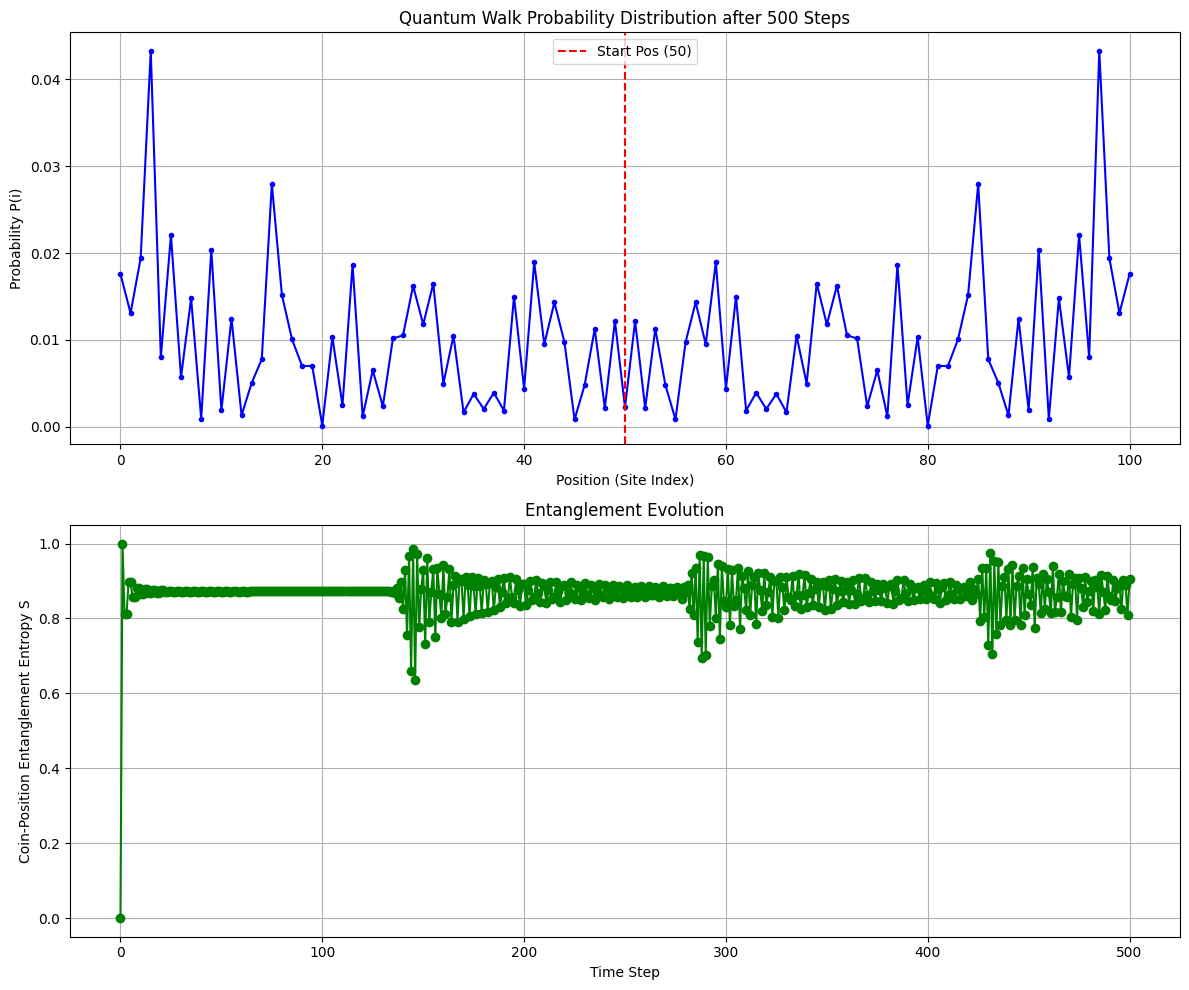

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors # Keep for optional plotting
# from scipy.linalg import logm # Not needed for von Neumann entropy from eigenvalues

# --- Parameters ---
N_SITES = 101    # Number of positions (odd for a center)
DEPTH = 500       # Number of steps (as before)
STATE_DIM = 2 * N_SITES

# --- Initial State ---
initial_state_vector = np.zeros(STATE_DIM, dtype=np.complex128)
center_pos = N_SITES // 2
initial_state_vector[2 * center_pos + 0] = 1.0 / np.sqrt(2) # Amplitude for |0, center>
initial_state_vector[2 * center_pos + 1] = 1.0j / np.sqrt(2) # Amplitude for |1, center>

# --- Build Unitary Matrices ---
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
I_sites = np.eye(N_SITES, dtype=np.complex128)
C_full = np.kron(I_sites, H)

S_full = np.zeros((STATE_DIM, STATE_DIM), dtype=np.complex128)
for i in range(N_SITES):
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_left = 2 * pos_left + 0
    pos_right = (i + 1) % N_SITES
    idx_right = 2 * pos_right + 1
    current_idx0 = 2*i + 0
    S_full[idx_left, current_idx0] = 1.0
    current_idx1 = 2*i + 1
    S_full[idx_right, current_idx1] = 1.0

U_step = S_full @ C_full

# --- Function to calculate Coin Entropy ---
def calculate_coin_entropy(state_vector, n_sites):
    """Calculates the entanglement entropy between coin and position."""
    state_dim = 2 * n_sites
    if len(state_vector) != state_dim:
        raise ValueError("State vector length mismatch")

    # 1. Construct full density matrix
    rho_full = np.outer(state_vector, np.conjugate(state_vector))

    # 2. Calculate reduced density matrix for the coin
    rho_coin = np.zeros((2, 2), dtype=np.complex128)
    for c in range(2): # row index of rho_coin
        for c_prime in range(2): # col index of rho_coin
            sum_val = 0.0
            for p in range(n_sites): # Sum over positions
                idx_k = 2*p + c
                idx_l = 2*p + c_prime
                if 0 <= idx_k < state_dim and 0 <= idx_l < state_dim:
                     sum_val += rho_full[idx_k, idx_l]
            rho_coin[c, c_prime] = sum_val

    # 3. Calculate Von Neumann Entropy
    # Check trace first for debugging
    trace_rho_coin = np.trace(rho_coin)
    if np.abs(trace_rho_coin - 1.0) > 1e-6:
         print(f"Warning: Trace of rho_coin is {trace_rho_coin:.6f}")
         # Optional: Normalize rho_coin if trace deviates significantly?
         # rho_coin /= trace_rho_coin

    eigenvalues = np.linalg.eigvalsh(rho_coin)
    entropy = 0.0
    for eig_val in eigenvalues:
        if eig_val > 1e-12: # Avoid log(0)
            entropy -= eig_val * np.log2(eig_val)
        elif eig_val < -1e-12: # Check for numerical issues
             print(f"Warning: Negative eigenvalue in rho_coin: {eig_val:.6e}")

    return np.real(entropy) # Entropy should be real


# --- Evolution Loop ---
current_state = initial_state_vector.copy()
state_history = [current_state.copy()] # Store t=0 state
coin_entropy_history = [calculate_coin_entropy(current_state, N_SITES)]

print(f"\nStarting Quantum Walk evolution for {DEPTH} steps...")
for step in range(DEPTH):
    current_state = U_step @ current_state
    # Optional: Normalize at each step if needed
    norm = np.linalg.norm(current_state)
    if np.abs(norm-1.0)>1e-9: current_state /= norm

    state_history.append(current_state.copy())
    coin_entropy_history.append(calculate_coin_entropy(current_state, N_SITES))

    if (step + 1) % 10 == 0:
         print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = state_history[-1]
time_axis = np.arange(DEPTH + 1) # 0 to DEPTH

# Calculate Final Probability Distribution P(i)
prob_dist = np.zeros(N_SITES)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = np.abs(amp_0)**2 + np.abs(amp_1)**2

print("\nFinal Probability Distribution Analysis:")
final_sum_prob = np.sum(prob_dist)
print(f"  Sum of probabilities P(i): {final_sum_prob:.6f}")

# --- Generate Text Output for Distribution ---
def generate_qw_text_output(prob_dist, coin_entropy_hist, n_sites, depth, max_bar_width=60):
    output_lines = []
    output_lines.append("\n--- Quantum Walk Final Probability Distribution & Entanglement ---")
    output_lines.append(f"N_sites = {n_sites}, Depth = {depth}")

    max_prob = np.max(prob_dist) if len(prob_dist) > 0 else 0
    if max_prob < 1e-9:
        scale = 0
    else:
        scale = max_bar_width / max_prob

    output_lines.append("\nSite | Probability | Distribution Chart")
    output_lines.append("-----|-------------|----------------------")
    for i in range(n_sites):
        prob = prob_dist[i]
        bar_length = int(prob * scale)
        bar = '#' * bar_length
        line = f"{i:<4} | {prob:<11.5f} | {bar}"
        output_lines.append(line)

    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    # Show first, middle, and last entropy values for brevity
    num_steps_total = len(coin_entropy_hist)
    indices_to_show = [0]
    if num_steps_total > 2:
        indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1:
         indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show))) # Remove duplicates if few steps

    for idx in indices_to_show:
         output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_hist[idx]:.6f}")

    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)

# Generate and print the text output
qw_text_summary = generate_qw_text_output(prob_dist, coin_entropy_history, N_SITES, DEPTH)
print(qw_text_summary)

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10)) # Two plots now

# Plot 1: Final Probability Distribution
axs[0].plot(range(N_SITES), prob_dist, marker='.', linestyle='-', color='blue')
center_pos = N_SITES // 2
axs[0].axvline(center_pos, color='red', linestyle='--', label=f'Start Pos ({center_pos})')
axs[0].set_xlabel("Position (Site Index)")
axs[0].set_ylabel("Probability P(i)")
axs[0].set_title(f"Quantum Walk Probability Distribution after {DEPTH} Steps")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Coin-Position Entanglement Entropy vs Time
axs[1].plot(time_axis, coin_entropy_history, marker='o', linestyle='-', color='green')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Coin-Position Entanglement Entropy S")
axs[1].set_title("Entanglement Evolution")
axs[1].grid(True)
axs[1].set_ylim(-0.05, 1.05) # Entropy is between 0 and log2(dim)=log2(2)=1

plt.tight_layout()
plt.show()

test n+3

Step Unitary U_step shape: (202, 202)

Starting Quantum Walk evolution for 500 steps with Phase Damping (P=0.010)...
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/500
  Completed step 270/500
  Completed step 280/500
  Completed step 290/500
  Completed step 300/500
  Completed step 310/500
  Completed step 320/500
  Completed step 330/500
  Completed step 340/500
  Completed step 350/500
  Completed step 

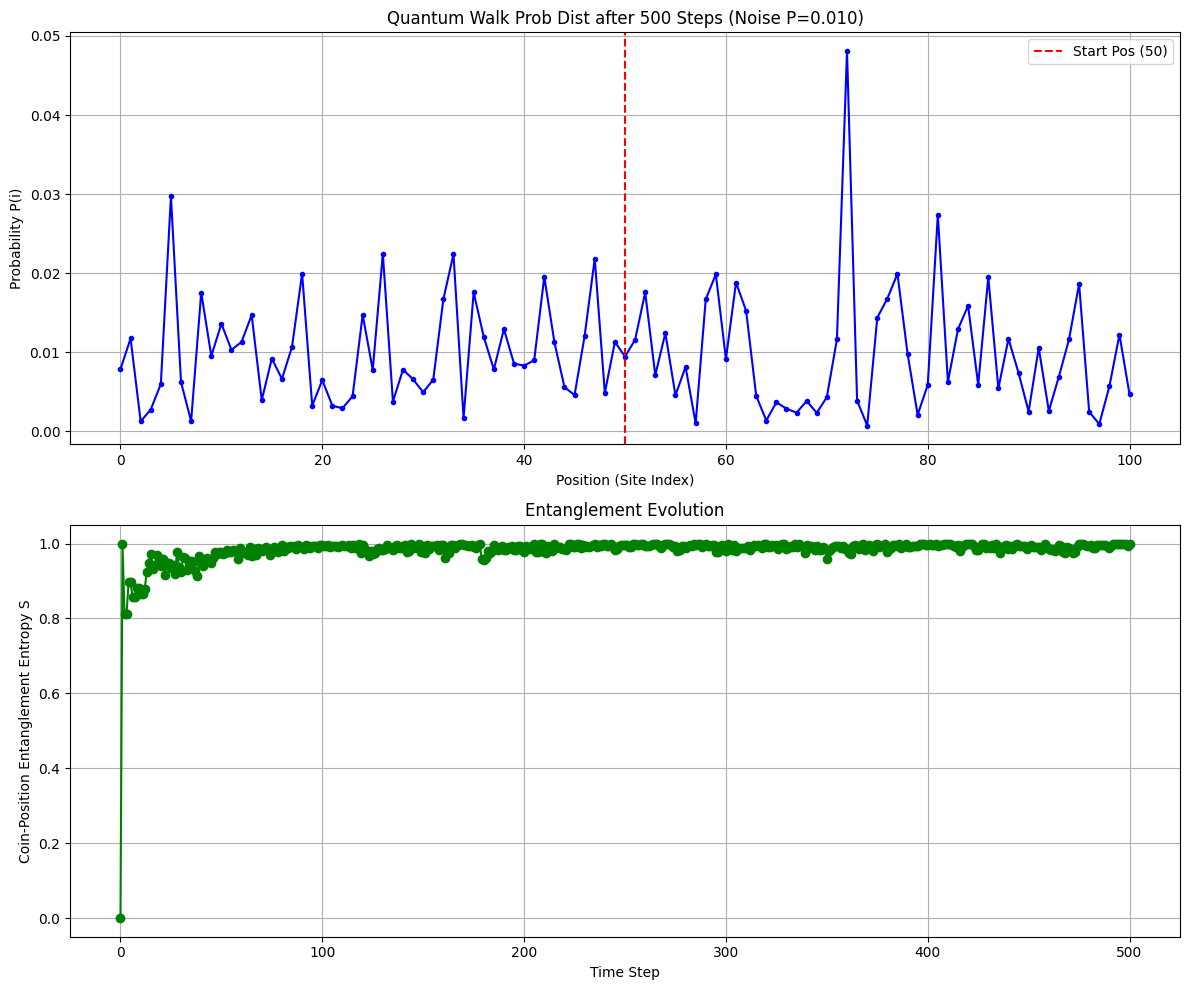

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random # Needed for probabilistic noise

# --- Parameters ---
N_SITES = 101    # Number of positions (odd for a center)
DEPTH = 500       # Number of steps
STATE_DIM = 2 * N_SITES
NOISE_PROB = 0.01 # Probability of Z error per qubit per step (e.g., 1%)

# --- Initial State ---
initial_state_vector = np.zeros(STATE_DIM, dtype=np.complex128)
center_pos = N_SITES // 2
initial_state_vector[2 * center_pos + 0] = 1.0 / np.sqrt(2) # Amp for |0, center>
initial_state_vector[2 * center_pos + 1] = 1.0j / np.sqrt(2) # Amp for |1, center>

# --- Build Unitary Matrices ---
H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
I_sites = np.eye(N_SITES, dtype=np.complex128)
C_full = np.kron(I_sites, H)

S_full = np.zeros((STATE_DIM, STATE_DIM), dtype=np.complex128)
for i in range(N_SITES):
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_left = 2 * pos_left + 0
    pos_right = (i + 1) % N_SITES
    idx_right = 2 * pos_right + 1
    current_idx0 = 2*i + 0
    S_full[idx_left, current_idx0] = 1.0
    current_idx1 = 2*i + 1
    S_full[idx_right, current_idx1] = 1.0

U_step = S_full @ C_full
print(f"Step Unitary U_step shape: {U_step.shape}")

# --- Helper to get system unitary for a single operation ---
# Using Circuit.unitary() - we know this might have issues, but Z is diagonal
def get_system_unitary_for_op(op: cirq.Operation, total_qubits: int, all_qubits: list[cirq.LineQubit]) -> np.ndarray:
    """
    Calculates the full (2^N x 2^N) unitary matrix for a single operation 'op'.
    Uses cirq.Circuit(op).unitary().
    """
    identity_matrix = np.eye(2**total_qubits, dtype=np.complex128)
    temp_circuit = cirq.Circuit(op)
    try:
        system_unitary = temp_circuit.unitary(
            qubit_order=all_qubits,
            qubits_that_should_be_present=all_qubits
        )
        expected_dim = 2**total_qubits
        if system_unitary.shape != (expected_dim, expected_dim):
             # print(f"Warning: Unitary shape mismatch for op {op}. Returning Identity.")
             return identity_matrix
        return system_unitary
    except Exception as e:
         # print(f"Warning: Circuit.unitary failed for op {op}: {e}. Returning Identity.")
         return identity_matrix

# --- Function to calculate Coin Entropy ---
# (Omitted for brevity - use previous version)
def calculate_coin_entropy(state_vector, n_sites):
    state_dim = 2 * n_sites
    if len(state_vector) != state_dim: raise ValueError("State vector length mismatch")
    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6: state_vector = state_vector / norm
    rho_full = np.outer(state_vector, np.conjugate(state_vector))
    rho_coin = np.zeros((2, 2), dtype=np.complex128)
    for c in range(2):
        for c_prime in range(2):
            sum_val = 0.0
            for p in range(n_sites):
                idx_k = 2*p + c
                idx_l = 2*p + c_prime
                if 0 <= idx_k < state_dim and 0 <= idx_l < state_dim: sum_val += rho_full[idx_k, idx_l]
            rho_coin[c, c_prime] = sum_val
    trace_rho_coin = np.trace(rho_coin)
    if np.abs(trace_rho_coin - 1.0) > 1e-6: pass # print(f"Warning: Trace of rho_coin is {trace_rho_coin:.6f}")
    eigenvalues = np.linalg.eigvalsh(rho_coin)
    entropy = 0.0
    for eig_val in eigenvalues:
        if eig_val > 1e-12: entropy -= eig_val * np.log2(eig_val)
        elif eig_val < -1e-12: pass # print(f"Warning: Negative eigenvalue in rho_coin: {eig_val:.6e}")
    return np.real(entropy)


# --- Evolution Loop with Noise---
current_state = initial_state_vector.copy()
state_history = [current_state.copy()]
coin_entropy_history = [calculate_coin_entropy(current_state, N_SITES)]
all_qubits_list = cirq.LineQubit.range(STATE_DIM) # Need this for get_system_unitary... wait, STATE_DIM is wrong here
# Corrected: all_qubits_list represents the individual qubit indices 0 to N_SITES*2-1 conceptually
# Need the list of LineQubit objects corresponding to the state vector basis order
# Our basis |c,p> means vector index k=2p+c. Qubit system is Coin @ Position.
# This noise model needs careful thought on which qubits to apply Z to.
# Let's apply it probabilistically to *each logical position* (affecting both coin states there?)
# OR apply to the *coin state* only?
# Simpler: Apply Z error to *each element of the state vector basis* representation? No.
# Apply Z error to each physical qubit location. Our state vector combines coin and position.
# Let's model noise acting independently on each effective site (position).
# For simplicity: At each step, iterate through SITES. With probability P, apply Z to *both* components at that site?
# Or, maybe simpler: iterate through the 2*N_SITES indices representing basis states |c,p>.
# Apply Z to the 'p' part? Or 'c' part?

# --- REVISED Noise Model: Apply Z to the COIN state at each site with probability P ---
# This is physically motivated - the internal coin state decoheres.
I_2 = np.eye(2, dtype=np.complex128)
Z_matrix = np.array([[1, 0], [0, -1]], dtype=np.complex128)
U_noise_operators = {} # Cache noise unitaries
for i in range(N_SITES):
    # Unitary for Z on coin at site i: I_site(0) @ ... @ Z_coin(i) @ ... @ I_site(N-1)
    # Using our basis |c,p> k=2p+c, this is complex with np.kron.

    # Let's try the probabilistic application on the state vector directly.
    # Applying Z to coin at site 'p' means multiplying amps for |1,p> by -1.
    pass # Abandoning direct unitary build for noise - too complex with kron order.

# --- REVISED Noise Model 2: Probabilistic Z Application to state vector components ---
# This simulates phase randomization between |0> and |1> coin states AT EACH SITE.

print(f"\nStarting Quantum Walk evolution for {DEPTH} steps with Phase Damping (P={NOISE_PROB:.3f})...")
current_state = initial_state_vector.copy()
# Need history for plotting entropy
coin_entropy_history = [calculate_coin_entropy(current_state, N_SITES)]

for step in range(DEPTH):
    # 1. Unitary Step
    current_state = U_step @ current_state

    # 2. Noise Step (Phase Damping on Coin at each site)
    if NOISE_PROB > 1e-9: # Apply noise only if probability is non-zero
        for i in range(N_SITES): # Iterate over each site
            if random.random() < NOISE_PROB:
                # Apply Z to coin at site i: Flip sign of |1, i> component
                idx1 = 2*i + 1
                if 0 <= idx1 < STATE_DIM:
                    current_state[idx1] *= -1.0

    # 3. Normalization (Important AFTER noise step which preserves norm)
    norm = np.linalg.norm(current_state)
    if np.abs(norm - 1.0) > 1e-6:
        # print(f"Norm after step {step+1}: {norm:.6f}. Renormalizing.") # Can be noisy
        current_state /= norm

    # 4. Store History (Store state AFTER noise and normalization)
    # state_history.append(current_state.copy()) # Don't store full state history unless needed
    coin_entropy_history.append(calculate_coin_entropy(current_state, N_SITES))

    if (step + 1) % 10 == 0:
         print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = current_state # Use the final state after all steps

# Calculate Final Probability Distribution P(i)
prob_dist = np.zeros(N_SITES)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = np.abs(amp_0)**2 + np.abs(amp_1)**2

print("\nFinal Probability Distribution Analysis:")
final_sum_prob = np.sum(prob_dist)
print(f"  Sum of probabilities P(i): {final_sum_prob:.6f}")
if np.abs(final_sum_prob - 1.0) > 1e-6:
    print("  WARNING: Total probability deviates significantly from 1.0!")


# --- Generate Text Output for Distribution ---
# (Omitted for brevity - use previous version)
def generate_qw_text_output(prob_dist, coin_entropy_hist, n_sites, depth, noise_prob, max_bar_width=60):
    output_lines = []
    output_lines.append("\n--- Quantum Walk Final Probability Distribution & Entanglement ---")
    output_lines.append(f"N_sites = {n_sites}, Depth = {depth}, Noise Prob = {noise_prob:.3f}")
    max_prob = np.max(prob_dist) if len(prob_dist) > 0 else 0
    if max_prob < 1e-9: scale = 0
    else: scale = max_bar_width / max_prob
    output_lines.append("\nSite | Probability | Distribution Chart")
    output_lines.append("-----|-------------|----------------------")
    for i in range(n_sites):
        prob = prob_dist[i]
        bar_length = int(prob * scale)
        bar = '#' * bar_length
        line = f"{i:<4} | {prob:<11.5f} | {bar}"
        output_lines.append(line)
    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    num_steps_total = len(coin_entropy_hist)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
         output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_hist[idx]:.6f}")
    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)

# Generate and print the text output
qw_text_summary = generate_qw_text_output(prob_dist, coin_entropy_history, N_SITES, DEPTH, NOISE_PROB)
print(qw_text_summary)

# --- Plotting ---
# (Omitted for brevity - use previous version)
time_axis = np.arange(DEPTH + 1) # 0 to DEPTH
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(range(N_SITES), prob_dist, marker='.', linestyle='-', color='blue')
center_pos = N_SITES // 2
axs[0].axvline(center_pos, color='red', linestyle='--', label=f'Start Pos ({center_pos})')
axs[0].set_xlabel("Position (Site Index)")
axs[0].set_ylabel("Probability P(i)")
axs[0].set_title(f"Quantum Walk Prob Dist after {DEPTH} Steps (Noise P={NOISE_PROB:.3f})")
axs[0].legend(); axs[0].grid(True)
axs[1].plot(time_axis, coin_entropy_history, marker='o', linestyle='-', color='green')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Coin-Position Entanglement Entropy S")
axs[1].set_title("Entanglement Evolution")
axs[1].grid(True); axs[1].set_ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()